# Forward modelling example

This notebook contains a simple example of forward modelling a single line of data over an ordnance object. 

In [1]:
code_dir = "../../UXO_protected/+BTInvertPY"

In [2]:
import sys
sys.path.append(code_dir)

from BTSensor import (
    SensorInfo, Model, preCalcLoopCorners, FModParam, 
    forwardWithQ, sensorCoords2RxCoords, hprimary, formQmatrix,
)
import numpy as np
import os
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d
import mpl_toolkits.mplot3d.art3d as art3d

In [3]:
afile = os.path.join(code_dir,'config','sensor_definitions','UltraTEMArrayNA___Default.yaml')
sensorinfo = SensorInfo.fromYAML(afile)[0]

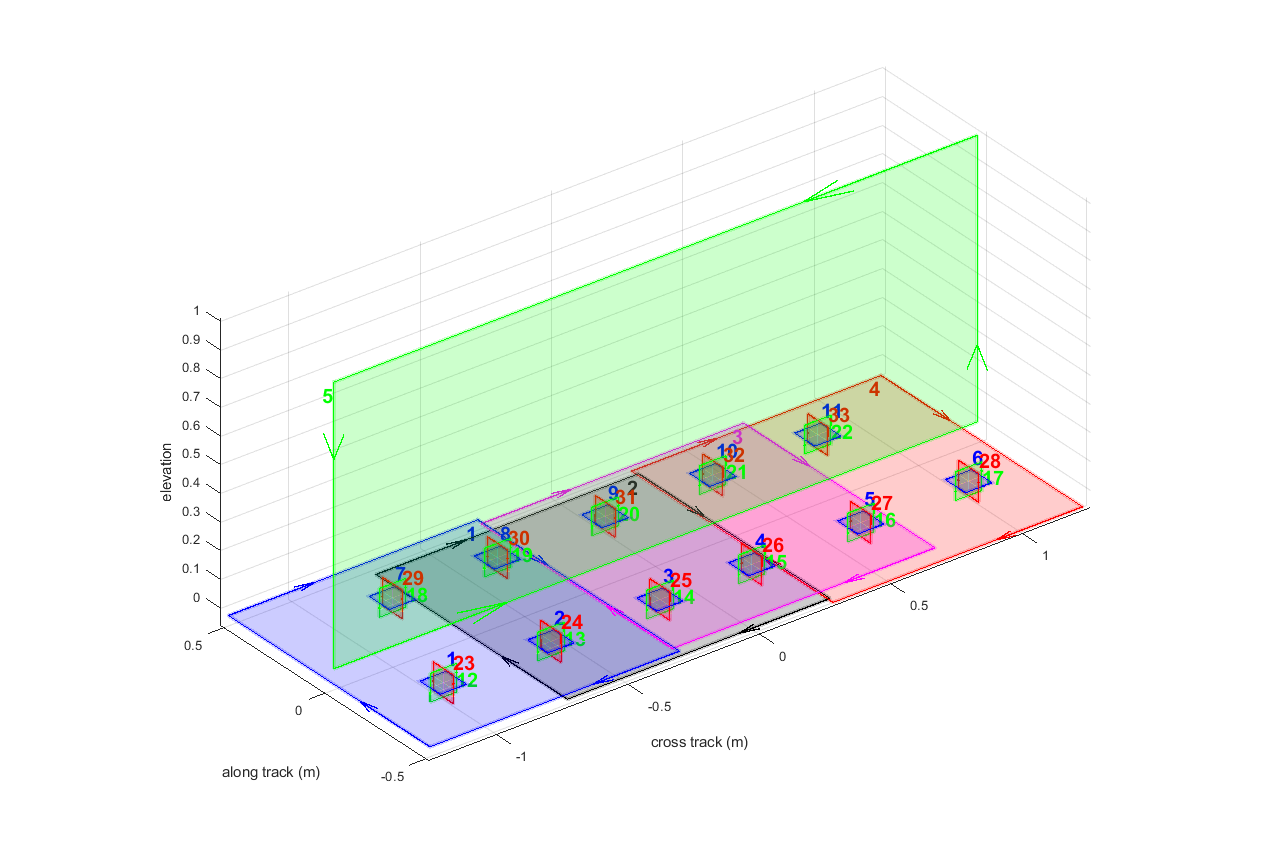

In [4]:
t = sensorinfo.transmitters[0]

In [5]:
for i, t in enumerate(sensorinfo.transmitters):
    shape = t.shape
    print(
        f"{i+1} "
        f"[{t.center[0]:1.2f}, {t.center[1]:1.2f}, {t.center[2]:1.2f}], "
        f"{shape[:, 0].max() - shape[:, 0].min():1.2f}, "
        f"{shape[:, 1].max() - shape[:, 1].min():1.2f}, "
        f"{shape[:, 2].max() - shape[:, 2].min():1.2f}, "
    )


1 [-0.77, 0.00, -0.02], 0.95, 1.00, 0.00, 
2 [-0.20, 0.00, -0.06], 1.00, 0.95, 0.00, 
3 [0.20, 0.00, -0.02], 1.00, 0.95, 0.00, 
4 [0.77, 0.00, -0.06], 0.95, 1.00, 0.00, 
5 [0.00, 0.00, 0.51], 2.45, 0.00, 1.00, 


Text(0.5, 0, 'y')

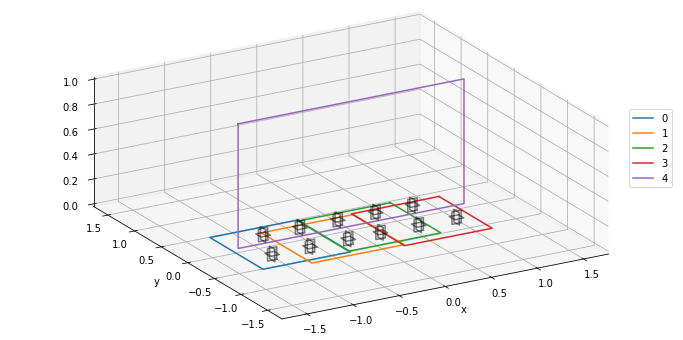

In [6]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection='3d', proj_type="ortho")

for i, t in enumerate(sensorinfo.transmitters):
    shape = t.shape
    shape = np.vstack([shape, shape[0, :]])
    ax.plot(shape[:, 0], shape[:, 1], shape[:, 2], color=f"C{i}", label=i)
    
for i, r in enumerate(sensorinfo.receivers):
    shape = r.shape
    shape = np.vstack([shape, shape[0, :]])
    ax.plot(shape[:, 0], shape[:, 1], shape[:, 2], color="k", alpha=0.5)
    

ax.legend(bbox_to_anchor=[0.8, 0.1, 0.2, 0.6])
ax.set_xlim([-1.7, 1.7])
ax.set_ylim([-1.7, 1.7])
ax.set_zlim([0, 1])
ax.view_init(elev=45, azim=240)

ax.set_xlabel("x")
ax.set_ylabel("y")


In [7]:
# Sensor location and attitude
nloc = 100 # number of tx firings, such that the sensor is considered stationary while recording data at each Rx
ntx = sensorinfo.transmitters.size
x = np.repeat(0., nloc)
y = 3 * np.linspace(-1, 1, nloc)
z = np.repeat(0.28, nloc) # sensor is placed 28cm above the ground.  This is the typical height for the UltraTEM NATA system
pitch = np.repeat(0., nloc)
roll = np.repeat(0., nloc)
yaw = np.repeat(0., nloc)  # moving north (sensor in typical orientation)
txnum = np.hstack(
    int(np.ceil(nloc/ntx))*[np.arange(len(sensorinfo.transmitters))]
)[0:nloc]  # just ensuring the tx firing sequence cycles over the number of locations, nloc

In [8]:
# Load the ordnance file
ord_file = os.path.join(code_dir,'ordnance_DoD_UltraTEM_5F_ISOsmall.h5')
f = h5py.File(ord_file, 'r')

In [9]:
f[f'ordnance/1/h5_Item_Orientation'][()].flatten()

array([b'V'], dtype='|S2')

In [10]:
ordi = 1 # 1-based index into the H5 structure

L3 = f[f'ordnance/{ordi}/L1ref'][()].flatten() 
L2 = f[f'ordnance/{ordi}/L2ref'][()].flatten()
L1 = f[f'ordnance/{ordi}/L3ref'][()].flatten()  # taken to be the greater polarizability 
times = f[f'ordnance/{ordi}/time'][()].flatten()
ord_name = f[f'ordnance/{ordi}/Name'][()][0]
f.close()

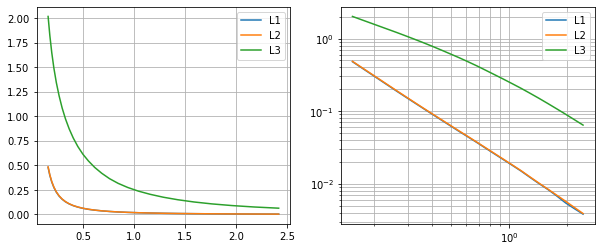

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for L, label in zip([L1, L2, L3], ["L1", "L2", "L3"]):
    ax[0].plot(times, L, label=label)
    ax[1].loglog(times, L, label=label)

for a in ax:
    a.grid(which="both")
    a.legend()

In [12]:
# Specify the source parameters
xyz = np.array([0 , 0, -0.30]) #  Source object location.
# ypr is yaw, pitch, roll.  Radians
ypr = np.array([0, 0, 0]) # horizontal and pointing north.  Use [0 pi/2 0] for a vertical item.
mod = Model(xyz=xyz, gba=ypr, l3=L3, l2=L2, l1=L1, times=times)

In [13]:
# Convert sensor location coordinates to Rx locations
pos, mnum = sensorCoords2RxCoords(
    sensorinfo=sensorinfo,
    x = x, 
    y = y, 
    z = z, 
    pitch = pitch, 
    roll = roll, 
    yaw = yaw,
    txnum = txnum
)

pitch = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(pitch)])
roll = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(roll)])
yaw = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(yaw)])
pos = np.concatenate(pos,axis=0)

In [14]:
tmp = sensorinfo.measurements[mnum[0]]

In [15]:
tmp.receivers

array([[0, 1]])

In [16]:
# forward model
Tx_indices_rot, Rx_indices_rot = preCalcLoopCorners(
    sensorinfo=sensorinfo, mnum=mnum, rlist=pos, pitch=pitch, roll=roll, yaw=yaw
) # figuring out where all of the vertices are in coordinate system -- gives us location of vertices 

st = FModParam(sensorinfo, pos, mnum, mod.times, Tx_indices_rot, Rx_indices_rot)  # convienence object for inputs to fwd modelling 

# Bp = hprimary(mod.xyz,st.pos,Tx_indices_rot[0],Tx_indices_rot[1],Tx_indices_rot[2])
# Q = formQmatrix(mod.xyz,st.pos,st.mnum,st.Tx_indices_rot[0],st.Tx_indices_rot[1],st.Tx_indices_rot[2],st.Rx_indices_rot[0],st.Rx_indices_rot[1],st.Rx_indices_rot[2])

V = forwardWithQ(mod, st) # nT/s (some version of db/dt)

In [17]:
V.shape  # receiver coordinates x time 

(3300, 27)

In [18]:
pos.shape

(3300, 3)

In [19]:
sensor_table = sensorinfo.measNum2TxRxRxcCube()
sensor_table = sensor_table[mnum, :]

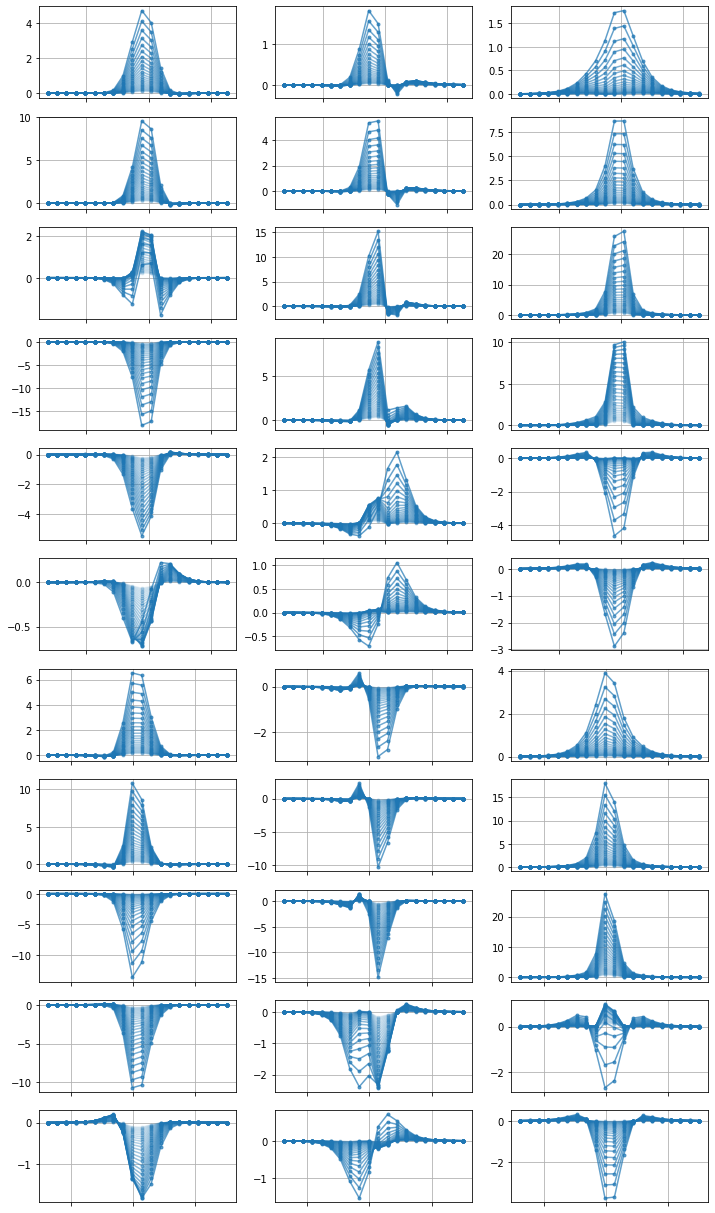

In [20]:
nrx = 11
fig, ax = plt.subplots(nrx, 3, figsize=(12, 2*nrx))

tx_ind = 0
cmap = cm.inferno(times)
                  
for rx in range(nrx):
    ii = (sensor_table[:, 0] == tx_ind) & (sensor_table[:, 3] == rx)
    
    for a, rx_comp in zip(ax[rx, :], [0, 1, 2]):
        iii = ii & (sensor_table[:, 2] == rx_comp)
        for t in range(len(times)):
            a.plot(
                pos[iii, 1], V[iii, t], '-', marker='.', color="C0", #color=cmap[t], 
                alpha= 0.1+0.6*(len(times) - t)/len(times)
            )
        a.grid(which="both")
        if rx < nrx:
            a.set_xticklabels('')

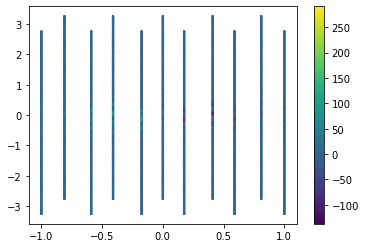

In [25]:
plt.colorbar(plt.scatter(pos[:, 0], pos[:, 1], c=V[:, 0], s=2))